<a name="outline"></a>

## Outline

- [Task 1](#task-1): Neural networks
  - [1.1](#q11) Multi-layer perceptron
  - [1.2](#q12) Convolutional neural network (CNN)
- [Task 2](#task-2): Unsupervised learning
  - [2.1](#q21) Dimensionality reduction and clustering of a subset of  the Fashion-MNIST image data
  - [2.2](#q22) Clustering of the feature matrix
  - [2.3](#q23) Graph-based analysis 
- [Task 3](#task-3): Mastery component 
  - [3.1](#q31) Non-Negative Matrix Factorization (NMF) for dimensionality reduction 
  - [3.2](#q32) Community detection


<a name="task-1"></a>
# Task 1: Neural networks [^](#outline)



<a name="q11"></a>

## 1.1 Multi-layer perceptron [^](#outline)



1.1.1

I have implemented a multi-layer perceptron

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
def load_data():
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
    x_train = x_train.astype('float32') / 255
    x_test = x_test.astype('float32') / 255
    # convert labels to categorical samples
    y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
    y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)
    return ((x_train, y_train), (x_test, y_test))
(x_train, y_train), (x_test, y_test) = load_data()

In [190]:
print(f'x train shape is : {x_train.shape}')
print(f'y train shape is : {y_train.shape}')
print(f'x test shape is : {x_test.shape}')
print(f'y test shape is : {y_test.shape}')

x train shape is : (60000, 28, 28)
y train shape is : (60000, 10)
x test shape is : (10000, 28, 28)
y test shape is : (10000, 10)


From just looking at the shape of the data loaded in, I can see that the training data has 60000 examples, and the test data has 10000 examples. However one thing that I do notice is that each example x data is a 2d array. This means that the pixels are still in their grid shape. To make calculations for the mlp easier I will convert this to a 1d array by flattening the 2d array. I can do this by just concatenating each row onto the end of the one before. Luckily for me, I can simply do this in a numpy function called reshape and this will work fine. I have called this function flatten_x to remind myself that only the x data needs to be flattened.

In [4]:
def flatten_x(x):
    '''
    Flatten current 2d image into 1d.
    Each different image is currently a 2d array of pixels,
    so will convert them to 1d to make calculations easier to understand
    
    parameters:
    x: K x height x width array of 2d inputs 
    
    returns:
    x_flat: K x (height x width) array of 1d inputs
    '''
    K, height, width = x.shape
    x_flat = x.reshape(K, height*width)
    return x_flat

In [191]:
x_train_flat = flatten_x(x_train)
x_test_flat = flatten_x(x_test)
print(f'x train flattened shape is : {x_train_flat.shape}')
print(f'x test shape flattened is : {x_test_flat.shape}')

x train flattened shape is : (60000, 784)
x test shape flattened is : (10000, 784)


As you can see above, the x data is now flattened so that each example is now a 1d array of size 784, which is indeed 28 x 28. Now the data is ready to be used by my mlp. To create my mlp, I will first start with the activation functions and their derivatives. I have implemented LeakyReLU and called the function the same name. $LeakyReLU(x, \alpha) =$ either $ \alpha x , x <0$ or $x,x \geq 0$. I have also implemented the derivative for LeakyReLU in a function called LeakyReLU_delta, in which I worked out the derivative to be: $LeakyReLU'(x, \alpha) =$ either $ \alpha , x <0$ or $1,x \geq 0$.

I have also implemented softmax and called the function the same name. $softmax(x)_i = \frac{e^{x_i}}{\sum_{j=1}^K e^{x_j}}$. The function I have just written out is for a 1d array, however I have adapted the function for use of 2d arrays where each row is a 1d array ready to be used in the function, and such will keep the number of rows throughout. This is because I want to be able to make use of dot products and such for stochastic gradient descent, be able to send the whole batch of values into the function instead of having to loop through and send one row at a time. I have also modified this algorithm further to prevent a return of inf. This occurs when very large values of $x_i$ are used and $e^{x_i}$ is so large that it returns it as infinity and then problems can happen. I solve this by simply finding the larger $x_i$ value and minus it from every data point. This means that now every $x_i \leq 0 $ and such when putting it in the power, won't go to infinity. This is very useful as it doesn't change the final result in the theoretical world, and now doesn't have infinity values. 

Next I implemented 

In [18]:
def Leaky_ReLU(x, alpha = 0.01):
    '''
    f(x) = alpha*x if x < 0, f(x) = x otherwise
    
    parameters:
    x: K x D array
    alpha: float set to 0.01
    
    returns:
    b: K x D array
    '''
    b = x*1.0
    ind_bel_0 = x < 0
    b[ind_bel_0] = alpha*x[ind_bel_0]
    return b


def Leaky_ReLU_delta(x, alpha = 0.01):
    '''
    f'(x) = alpha if x < 0, f'(x) = 1 otherwise
    
    parameters:
    x: K x D array
    alpha: float set to 0.01
    
    returns:
    b: K x D array
    '''
    b = np.ones(x.shape)
    ind_bel_0 = x < 0
    b[ind_bel_0] = alpha
    return b


def soft_max(x):
    '''
    f(x_i) = exp(x_i)/sum_j=1^K(exp(x_j))
    
    parameters:
    x: K x D array
    
    returns:
    b: K x D numpy array
    '''
    max_ = np.max(x, axis=1, keepdims=True)
    e = np.exp(x-max_)
    s = np.sum(e, axis=1, keepdims=True)
    b = e/s
    return b


def categorical_cross_entropy_loss(y_pred, y):
    '''
    f(...) = sum_i=1^K(y*log(y_pred))
    
    parameters:
    y_pred: K x 10 array of predicted outputs
    y: K x 10 array of outputs
    
    returns: 
    loss: float categorical cross entropy computed on this batch of inputs and outputs
    '''
    log_y_pred = np.log(y_pred)
    ce = y*log_y_pred
    loss = - np.mean(np.sum(ce, axis=1))
    return loss


def final_delta(y_pred, y):
    '''
    f(h, y) = y_pred - y
    
    parameters:
    y_pred: K x 10 array for the final post-activation vectors
    y: K x 10 array of outputs
    
    returns:
    delta: K x 10 array of deltas for the final weights and biases
    '''
    delta = (y_pred - y)
    return delta


def normal_delta(a, W, delta_1):
    '''
    f(a, W, delta_1) = Leaky_ReLU'(a) @ W * delta_1
    
    parameters:
    a: K x N array for the pre-activation vectors for k
    W: M x N array of kernel matrix parameters for k
    delta_1: K x M array of delta values for k+1
    
    returns:
    delta: K x N array of deltas for the k weights and biases
    '''
    leaky_delta = Leaky_ReLU_delta(a)
    W_delta_1 = np.dot(W.T, delta_1.T)
    delta = leaky_delta*W_delta_1.T
    return delta


def grad(x_batch, y_batch, Weights, a, h):
    '''
    Works out the gradient of the 
    loss function against the wieghts and biases
    
    parameters:
    x_batch: K x D array of inputs
    y_batch: K x 10 array of outputs
    Weights: n x dif x dif list of all kernel matrix parameter arrays
    a: (n+1) x K x dif list of all pre-activation arrays, a[0] = [0]
    h: (n+1) x K x dif list of all post-activation arrays
    
    returns: 
    grad_Weights: n x dif x dif list of all the gradients for the kernel matrixes
    grad_biases: n x dif list of all the gradients for the biases
    '''
    if len(Weights) == len(biases):
        num = len(Weights)
        K = len(x_batch)
    else:
        raise ValueError()
    
    # initialise list of all arrays
    grad_Weights = [0]*num
    grad_biases = [0]*num
    
    y_pred = h[num]*1.0
    h_i = h[num-1]*1.0
    # get a K x 10 array for delta_num
    delta_i_1 = final_delta(y_pred, y_batch)
    # need to average out all biases over K values
    grad_biases[num-1] = np.mean(delta_i_1, axis=0)
    # have to divide by K to get the average weight,
    # as the dot product already sums all K together
    grad_Weights[num-1] = np.dot(delta_i_1.T, h_i)/K
    
    for i in range(num-2, -1, -1):
        W_i_1 = Weights[i+1]*1.0
        delta_i_2 = delta_i_1*1.0
        a_i_1 = a[i+1]*1.0
        h_i = h[i]*1.0
        
        delta_i_1 = normal_delta(a_i_1, W_i_1, delta_i_2)
        grad_biases[i] = np.mean(delta_i_1, axis=0)
        grad_Weights[i] = np.dot(delta_i_1.T, h_i)/K

    return grad_Weights, grad_biases


def sgd(x, y, Weights, biases, mini_batch_size = 256, learning_rate = 0.001):
    '''
    Stochastic Gradient Descent in place for Weights and biases
    
    parameters:
    x: K x D array of inputs
    y: K x 10 array of outputs
    Weights: n x dif x dif list of all kernel matrix parameter arrays
    biases: n x dif list of all bias parameter arrays
    mini_batch_size: int for size of mini batches
    learning_rate: float for scaling the gradient
    '''
    K = np.size(x, 0)
    
    # create a random list of mini batches of size batch_size to use
    mini_batches = np.split(np.random.permutation(np.arange(K)), [mini_batch_size*i for i in range(1, (K-1)//mini_batch_size+1)])
    
    for mini_batch in mini_batches:
        x_batch = x[mini_batch]
        y_batch = y[mini_batch]
        a, h = mlp(x_batch, Weights, biases)
        grad_Weights, grad_biases = grad(x_batch, y_batch, Weights, a, h)
        
        for i, (grad_W, grad_b) in enumerate(zip(grad_Weights, grad_biases)):
            Weights[i] = Weights[i] - learning_rate*grad_W
            biases[i] = biases[i] - learning_rate*grad_b


def dense(h, W, b):
    '''
    Works out the pre-activaion array a
    
    parameters:
    h: K x M array of inputs
    W: N x M array for kernel matrix parameters
    b: N 1d array for bias parameters
    
    returns:
    a: K x N output array 
    '''
    
    a = np.dot(h, W.T) + b
    return a


def mlp(x, Weights, biases, only_return_pred = False):
    '''
    Multi-layer Perceptron with 5 input layers prediction
    
    parameters:
    x: K x D array of inputs
    Weights: n x dif x dif list of all kernel matrix parameter arrays
    biases: n x dif list of all bias parameter arrays
    only_return_pred: False, if true wil only return final predictions, 
                      if false will return all a and h values
    
    returns: 
    a: (n+1) x dif x dif list of all pre-activation arrays
    h: (n+1) x dif x dif list of all post-activation arrays
    y_pred: K x 10 output array of predictions
    '''
    # check that there are the same number of weight matrices as bias vectors
    if len(Weights) == len(biases):
        num = len(Weights)
    else:
        raise ValueError()
    
    # initialise list of all arrays
    a = [0]*(num+1)
    h = [0]*(num+1)

    # initialise h_0
    h[0] = x*1.0
    # keep a[0] = [0] to keep the indexes consistent, is never needed though
    
    for i, (W, b) in enumerate(zip(Weights, biases), 1):
        # work out a pre-activation
        a[i] = dense(h[i-1], W, b)
        if i != num:
            # work out h post-activation
            h[i] = Leaky_ReLU(a[i])
        else:
            # work out the final prediction, final h post-activation
            if only_return_pred:
                y_pred = soft_max(a[i])
                # if only return pred is true,
                # it only returns the final post-activations.
                # This is how you would test the function on test data
                return y_pred
            h[i] = soft_max(a[i])
    return a, h


def train_mlp(x, y, x_test, y_test, Weights, biases, mini_batch_size = 256, epochs = 40, learning_rate = 0.001, plot_losses = False, plot_accs = False):
    '''
    Train an mlp using stochastic gradient descent, update Weights and biases in place
    
    parameters:
    x: K x D array of inputs
    y: K x 10 array of outputs
    x: K x D array of inputs to test
    y: K x 10 array of outputs to test
    Weights: n x dif x dif list of all kernel matrix parameter arrays
    biases: n x dif list of all bias parameter arrays
    mini_batch_size: int for size of mini batches
    epochs: int of number of iteratins over the whole training data to do
    learning_rate: float for scaling the gradient
    plot_losses: bool for whether to plot losses against epochs
    plot_acc: bool for whether to plot accuracy against epochs
    
    returns:
    losses: list of losses for the train x for each epoch
    losses_test: list of losses for the test x for each epoch
    accs: list of accuracies for the train x for each epoch
    accs_test: list of accuracies for the test x for each epoch
    '''
    y_pred = mlp(x, Weights, biases, only_return_pred = True)
    losses = [categorical_cross_entropy_loss(y_pred, y)]
    accs = [accuracy(y_pred, y)]
    y_pred_test = mlp(x_test, Weights, biases, only_return_pred = True)
    losses_test = [categorical_cross_entropy_loss(y_pred_test, y_test)]
    accs_test = [accuracy(y_pred_test, y_test)]
    for epoch in range(epochs):
        sgd(x, y, Weights, biases, mini_batch_size = mini_batch_size, learning_rate = learning_rate)
        
        y_pred = mlp(x, Weights, biases, only_return_pred = True)
        losses = losses + [categorical_cross_entropy_loss(y_pred, y)]
        accs = accs + [accuracy(y_pred, y)]
        
        y_pred_test = mlp(x_test, Weights, biases, only_return_pred = True)
        losses_test = losses_test + [categorical_cross_entropy_loss(y_pred_test, y_test)]
        accs_test = accs_test + [accuracy(y_pred_test, y_test)]
    
    if plot_losses:
        plot_loss(losses, losses_test)
    
    if plot_accs:
        plot_acc(accs, accs_test)
        
    return losses, losses_test, accs, accs_test


def accuracy(y_preds, ys):
    '''
    Work out the accuracy of the mlp
    
    parameters:
    y_pred: K x 10 array of predicted outputs
    y: K x 10 array of outputs
    
    returns: 
    acc: float accuracy of the predictions made from the mlp
    '''
    K = np.size(ys, 0)
    acc = 0
    for i, (y_pred, y) in enumerate(zip(y_preds, ys)):
        if np.argmax(y_pred) == np.argmax(y):
            acc = acc + 1
    acc = acc/K
    return acc


def generate_W_b(in_num, out_num):
    '''
    Generate a random W, b for given in and out neuron numbers
    
    parameters:
    in_num: int of the number of input neurons
    out_num: int of the number of output neurons
    
    returns:
    W: out_num x in_num array random kernel matrix parameters
    b: out_num x 1 array of zeros
    '''
    np.random.seed(1892*in_num)
    var = 2. / (in_num + out_num)
    W = np.random.randn(out_num, in_num) * np.sqrt(var)
    b = np.zeros(out_num)
    return W, b


def create_mlp(num_neurons):
    '''
    Create the Weights and biases for a mlp with the given num_neurons.
    This mlp with have n hidden layers.
    
    parameters:
    num_neurons: n+2 1d array of the number of nearons on each layer,
                 starting with input and ending with output
    
    returns:
    Weights: (n+1) x dif x dif list of all kernel matrix parameter arrays
    biases: (n+1) x dif list of all bias parameter arrays
    '''
    num = len(num_neurons) - 1
    Weights = [0]*num
    biases = [0]*num
    for i in range(num):
        Weights[i], biases[i] = generate_W_b(num_neurons[i], num_neurons[i+1])
    return Weights, biases


def plot_loss(losses, losses_test):
    '''
    Plot the Categorical Cross-Entropy Loss against Epochs
    
    parameters:
    losses: epoch+1 list of losses from the training data for each epoch
    losses_test: epoch+1 list of losses from the test data for each epoch
    '''
    plt.figure(figsize=(12,8))
    plt.title('Loss vs Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Categorical Cross-Entropy Loss')
    plt.plot(losses)
    plt.plot(losses_test)
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.show()


def plot_acc(accs, accs_test):
    '''
    Plot the Categorical Accuracy against Epochs
    
    parameters:
    accs: epoch+1 list of accuracies from the training data for each epoch
    accs_test: epoch+1 list of accuracies from the test data for each epoch
    '''
    plt.figure(figsize=(12,8))
    plt.title('Accuracy vs Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Categorical Accuracy')
    plt.plot(accs)
    plt.plot(accs_test)
    plt.legend(['Train', 'Test'], loc='lower right')
    plt.show()

In [19]:
1e-3

0.001

Now I can create an mlp to test the functions I have created.

In [530]:
input_neurons = [np.size(x_train_flat, 1)]
hidden_neurons = [400]*5
output_neurons = [np.size(y_train, 1)]
num_neurons = input_neurons + hidden_neurons + output_neurons
print(num_neurons)

[784, 400, 400, 400, 400, 400, 10]


From the list num_neurons you can see the different amounts of neurons in each layer, with the input neurons being all the pixels from the picture, totalling at 784 as we saw before. Then this feeds into the first hidden layer of 400 neurons. There are 5 hidden layers all of 400 neurons, and this can be seen from the list also. Then after the final hidden layer it goes into the output layer where it makes its decision out of the 10 items it could be. This is the structure of our mlp and now we can create a randomly generated mlp fitting to this structure.

In [531]:
Weights, biases = create_mlp(num_neurons)
print(f'Weights length is : {len(Weights)}')
print(f'biases length is : {len(biases)}')
for i, (W, b) in enumerate(zip(Weights, biases)):
    print(f'Weights {i} shape is : {W.shape}')
    print(f'biases {i} shape is : {b.shape}')

Weights length is : 6
biases length is : 6
Weights 0 shape is : (400, 784)
biases 0 shape is : (400,)
Weights 1 shape is : (400, 400)
biases 1 shape is : (400,)
Weights 2 shape is : (400, 400)
biases 2 shape is : (400,)
Weights 3 shape is : (400, 400)
biases 3 shape is : (400,)
Weights 4 shape is : (400, 400)
biases 4 shape is : (400,)
Weights 5 shape is : (10, 400)
biases 5 shape is : (10,)


Above I have printed the shapes of each Weight and bias for each layer. I have setup the Weights matrices so that the dense function can work by $a^{i+1} = W^ih^i + b^i$, where $a^{i+1}$ is the next pre-activation vector, $W^i$ is the Weights matrix and $b^i$ is the bias vector. This is how I intended to setup the dense function, however when sending it multiple $h^i$ values for multiple data points, I would've then needed to transpose the $h^i$ so that each data poit stayed separated, and then would've needed to transpose it again so that the data points were still in the rows. I overcome this by adjusting the formula to $a^{i+1} = h^i(W^i)^T + b^i$ and such this allows for me to send it multiple data points at a time. This also then keeps the shape of W in line with the original formula and therefore allows me to use that structure throughout the rest of the functions. Next I am going to test my mlp function to see if the Weights and biases I have created will actually give me predictions.

In [532]:
x_1 = (x_train_flat[0]*1.0)[np.newaxis, ...]

y_1_pred = np.squeeze(mlp(x_1, Weights, biases, only_return_pred = True))
y_1_pred_1 = np.zeros(10)
y_1_pred_1[np.argmax(y_1_pred)] = 1.
y_1 = y_train[0]

print('Using just the first example in the train data')
print('The random mlp predicted this outcome')
print(y_1_pred)
print('The one predicted outcome from the random mlp')
print(y_1_pred_1)
print('The actual outcome should have been')
print(y_1)

Using just the first example in the train data
The random mlp predicted this outcome
[0.07635307 0.08603064 0.12064372 0.11155845 0.1047352  0.09273735
 0.07818666 0.10108165 0.1134929  0.11518036]
The one predicted outcome from the random mlp
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
The actual outcome should have been
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


From the above example I can see that the current mlp with the randomly chosen Weights and no biases, creates a random prediction with all categories scoring very similarly. The actual prediction I have shown would've been the 3rd category, however the actual outcome should've been the 10th category. This is a misclassification, but from looking at the actual predictions it had no idea what the actual outcome was, with no clearly larger value than all the rest. This is to be expected by a random mlp, however after training the data we hope to see a classification become more distinct and hopefully, if we have coded it correctly, the classification will be the correct one. I will now test this on the whole train and test data to see in total how many it can predict correctly from random.

In [533]:
y_pred = mlp(x_train_flat, Weights, biases, only_return_pred = True)
loss = categorical_cross_entropy_loss(y_pred, y_train)
acc = accuracy(y_pred, y_train)

y_pred_test = mlp(x_test_flat, Weights, biases, only_return_pred = True)
loss_test = categorical_cross_entropy_loss(y_pred_test, y_test)
acc_test = accuracy(y_pred_test, y_test)

print('Using the intial random Weights and 0 biases I am going to predict the data')
print(f'The loss on the train data is : {loss}')
print(f'The loss on the test data is : {loss_test}')
print(f'The accuracy on the train data is : {acc}')
print(f'The accuracy on the test data is : {acc_test}')

Using the intial random Weights and 0 biases I am going to predict the data
The loss on the train data is : 2.301548482499138
The loss on the test data is : 2.3022951182023523
The accuracy on the train data is : 0.112
The accuracy on the test data is : 0.114


From the above prints, I can see that the random mlp model isn't very good at classifying images into their correct classification. I can also see that the Categorical Cross-Entropy Loss for a random mlp is around 0.23 and such should be taken as an upper bound from which to test the training function to see if it is reducing this value, which is what this train mlp function is designed to do. I can also see that the Categorical Accuracy for both the train and test data is around 10 percent, which is very reassuring, because that is the epected percentage of correct guesses by random with a 1 in 10 chance. We will also take this as our lower bound for the accuracy and hope to improve this when we train our model. I will now train the mlp model with the instructions given in the question of 1.1.1. This is 40 epochs, learning rate of $1e-3$ and mini batches of size 256. I will also plot both the train and test loss and accuracy on graphs to summarize the progression through the training process.

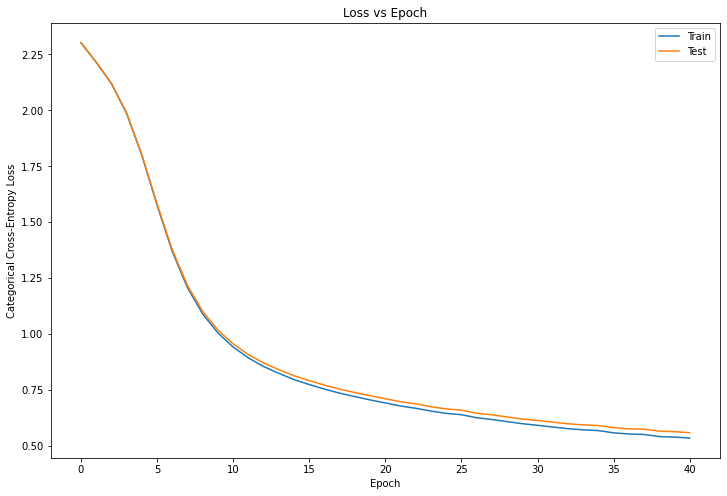

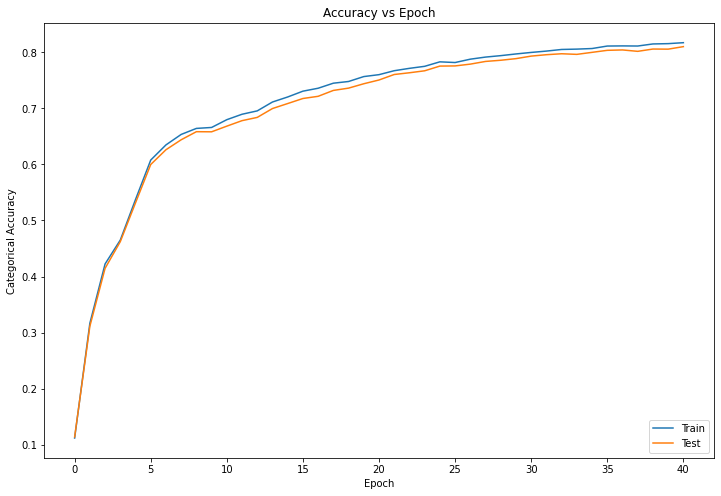

In [534]:
x_1_1_1 = x_train_flat*1.0
y_1_1_1 = y_train*1.0
Weights_1_1_1 = Weights*1
biases_1_1_1 = biases*1
x_test_1_1_1 = x_test_flat*1.0
y_test_1_1_1 = y_test*1.0
train_mlp(x_1_1_1, y_1_1_1, x_test_1_1_1, y_test_1_1_1, Weights_1_1_1, biases_1_1_1, mini_batch_size = 256, epochs = 40, learning_rate = 0.001, plot_losses = True, plot_accs = True)

1.1.2

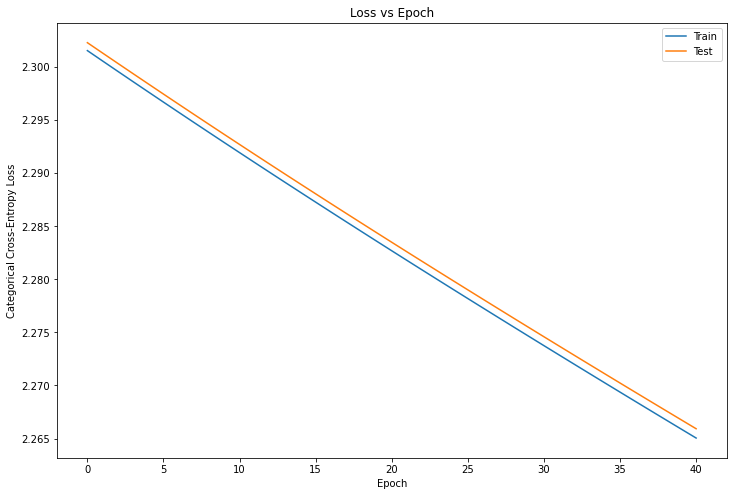

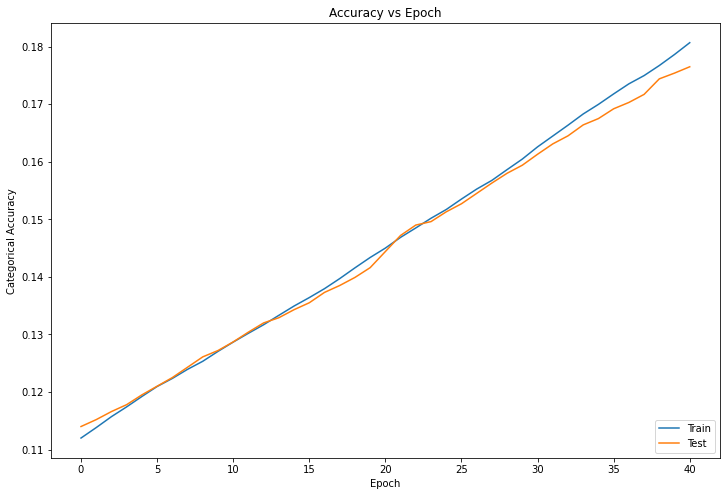

In [535]:
x_1_1_2i = x_train_flat*1.0
y_1_1_2i = y_train*1.0
Weights_1_1_2i = Weights*1
biases_1_1_2i = biases*1
x_test_1_1_2i = x_test_flat*1.0
y_test_1_1_2i = y_test*1.0
train_mlp(x_1_1_2i, y_1_1_2i, x_test_1_1_2i, y_test_1_1_2i, Weights_1_1_2i, biases_1_1_2i, mini_batch_size = 256, epochs = 40, learning_rate = 0.00001, plot_losses = True, plot_accs = True)

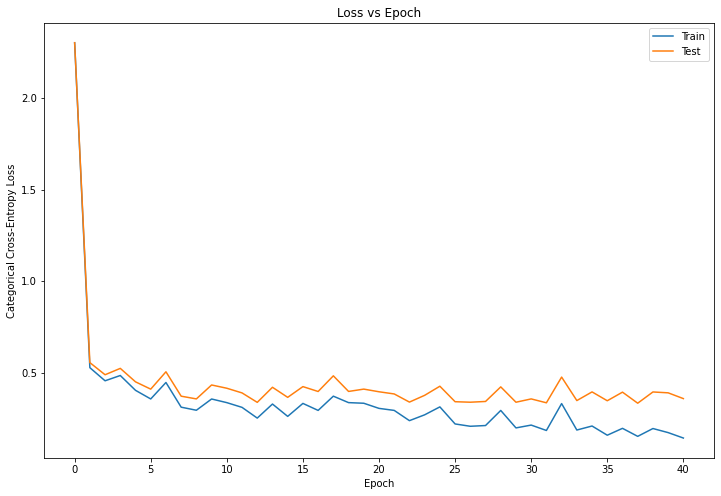

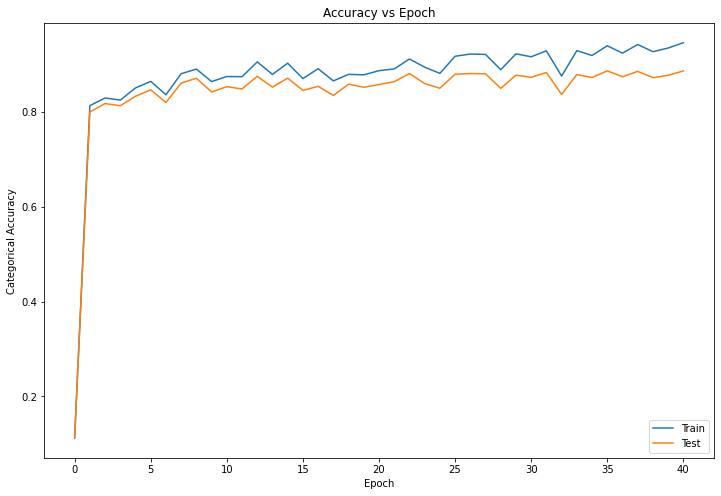

In [536]:
x_1_1_2ii = x_train_flat*1.0
y_1_1_2ii = y_train*1.0
Weights_1_1_2ii = Weights*1
biases_1_1_2ii = biases*1
x_test_1_1_2ii = x_test_flat*1.0
y_test_1_1_2ii = y_test*1.0
train_mlp(x_1_1_2ii, y_1_1_2ii, x_test_1_1_2ii, y_test_1_1_2ii, Weights_1_1_2ii, biases_1_1_2ii, mini_batch_size = 256, epochs = 40, learning_rate = 0.1, plot_losses = True, plot_accs = True)

1.1.3

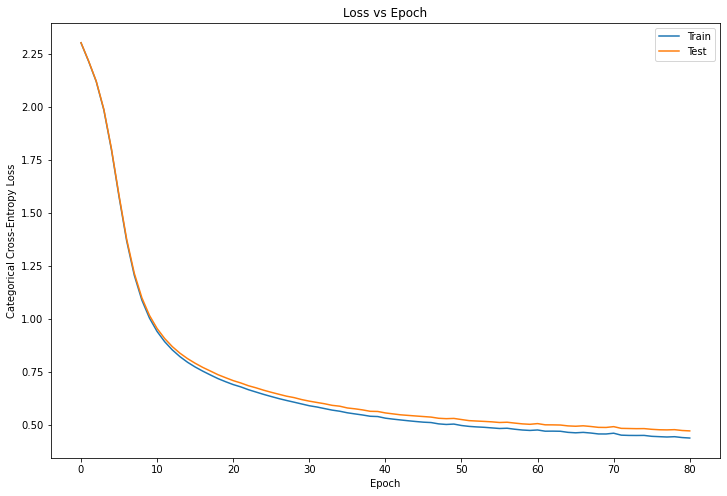

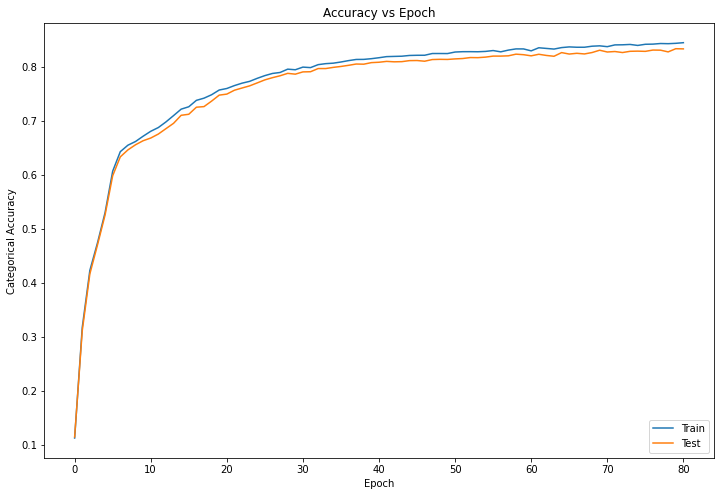

In [537]:
x_1_1_3 = x_train_flat*1.0
y_1_1_3 = y_train*1.0
Weights_1_1_3 = Weights*1
biases_1_1_3 = biases*1
x_test_1_1_3 = x_test_flat*1.0
y_test_1_1_3 = y_test*1.0
train_mlp(x_1_1_3, y_1_1_3, x_test_1_1_3, y_test_1_1_3, Weights_1_1_3, biases_1_1_3, mini_batch_size = 256, epochs = 80, learning_rate = 0.001, plot_losses = True, plot_accs = True)

<a name="q12"></a>
## 1.2 Convolutional neural network (CNN) [^](#outline)

1.2.1

In [21]:
# Define the model with Input, Conv2D, MaxPool2D, Flatten and Dense layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Input, Dense, Conv2D, MaxPool2D, LeakyReLU
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import SGD
alpha = 0.01
model_1_2_1 = Sequential([
    Input((28, 28, 1)),
    Conv2D(8, (3, 3), activation=LeakyReLU(alpha=alpha)),
    Conv2D(8, (3, 3), activation=LeakyReLU(alpha=alpha)),
    Conv2D(16, (3, 3), activation=LeakyReLU(alpha=alpha)),
    Conv2D(16, (3, 3), activation=LeakyReLU(alpha=alpha)),
    MaxPool2D((2, 2)),
    Flatten(),
    Dense(64, activation=LeakyReLU(alpha=alpha)),
    Dense(10, activation='softmax')
])

# Print the model summary
model_1_2_1.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 26, 26, 8)         80        
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 24, 24, 8)         584       
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 22, 22, 16)        1168      
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 20, 20, 16)        2320      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 10, 10, 16)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_26 (Dense)             (None, 64)               

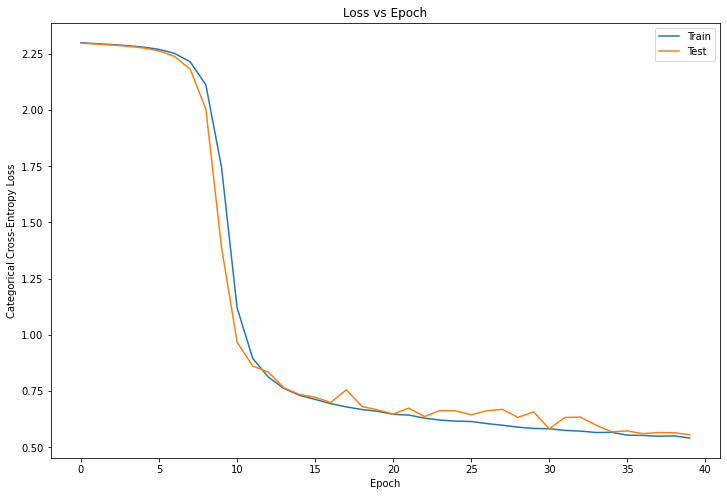

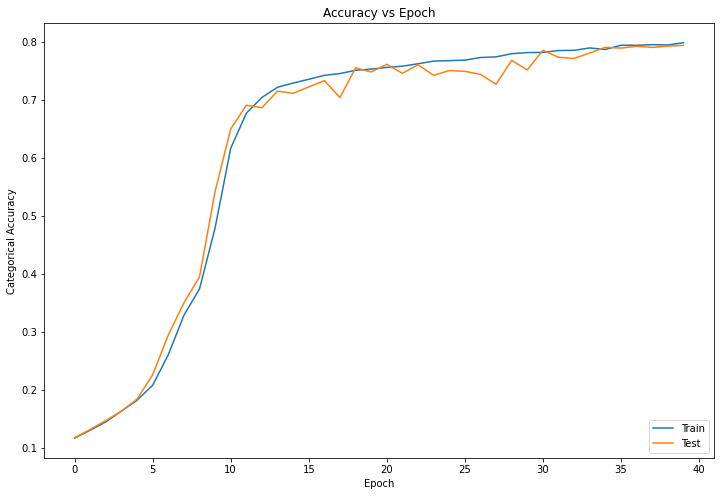

In [22]:
learning_rate = 0.001
model_1_2_1.compile(optimizer=SGD(learning_rate=learning_rate), loss=CategoricalCrossentropy(), metrics=['accuracy'])
x_1_2_1 = (x_train*1.0)[..., np.newaxis]
y_1_2_1 = (y_train*1.0)
x_test_1_2_1 = (x_test*1.0)[..., np.newaxis]
y_test_1_2_1 = (y_test*1.0)
epochs=40

history_1_2_1 = model_1_2_1.fit(x_1_2_1, y_1_2_1, batch_size=256, epochs=epochs, validation_data=(x_test_1_2_1, y_test_1_2_1), verbose=False)

plot_loss(history_1_2_1.history['loss'], history_1_2_1.history['val_loss'])

plot_acc(history_1_2_1.history['accuracy'], history_1_2_1.history['val_accuracy'])

1.2.2

In [23]:
# Define the model with Input, Conv2D, MaxPool2D, Flatten, Dense and Dropout layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Input, Dense, Conv2D, MaxPool2D, LeakyReLU

def CNN_dropout(rate=0, alpha=0.01):
    '''
    Create the CNN with dropout model.
    
    parameters:
    rate: float for the dropout rate to use, between 0-1 and set to 0 by default.
    alpha: float for the LeakyReLU alpha
    
    returns:
    model: tf model for the CNN with dropout
    '''
    model = Sequential([
        Input((28, 28, 1)),
        Conv2D(8, (3, 3), activation=LeakyReLU(alpha=alpha)),
        Conv2D(8, (3, 3), activation=LeakyReLU(alpha=alpha)),
        Conv2D(16, (3, 3), activation=LeakyReLU(alpha=alpha)),
        Conv2D(16, (3, 3), activation=LeakyReLU(alpha=alpha)),
        MaxPool2D((2, 2)),
        Flatten(),
        Dense(64, activation=LeakyReLU(alpha=alpha)),
        Dropout(rate),
        Dense(10, activation='softmax')
    ])
    return model


def Optimise_dropout_rate(x, y, x_val, y_val, epochs=40, learning_rate=0.001, batch_size=256, rate_range=[x/10 for x in range(1, 10)]):
    '''
    Using the rate_range as the values of dropout rate to use,
    I will work out the best accuracy on the validation set as the best dropout rate.
    
    parameters:
    num_neurons: n+2 1d array of the number of nearons on each layer,
                 starting with input and ending with output
    
    returns:
    Weights: (n+1) x dif x dif list of all kernel matrix parameter arrays
    biases: (n+1) x dif list of all bias parameter arrays
    '''
    num = len(rate_range)
    val_accuracy = []
    accuracy = []
    val_loss = []
    loss = []
    for i, rate in enumerate(rate_range):
        model = CNN_dropout(rate=rate)
        model.compile(optimizer=SGD(learning_rate=learning_rate), loss=CategoricalCrossentropy(), metrics=['accuracy'])
        history = model.fit(x, y, batch_size=batch_size, epochs=epochs, validation_data=(x_val, y_val), verbose=False)
        accuracy.append(history.history['accuracy'][-1])
        val_accuracy.append(history.history['val_accuracy'][-1])
        loss.append(history.history['loss'][-1])
        val_loss.append(history.history['val_loss'][-1])
    plot_loss_dropout(loss, val_loss, rate_range)
    plot_acc_dropout(accuracy, val_accuracy, rate_range)
    
    max_acc = max(val_accuracy)
    max_acc_index = val_accuracy.index(max_acc)
    optimal_rate = rate_range[max_acc_index]
    return optimal_rate, max_acc


def plot_loss_dropout(losses, losses_test, dropout_range):
    '''
    Plot the Categorical Cross-Entropy Loss against Dropout Rate
    
    parameters:
    losses: N list of losses from the training data for each dropout rate
    losses_test: N list of losses from the test data for each dropout rate
    dropout_range: N list of dropout rates
    '''
    plt.figure(figsize=(12,8))
    plt.title('Loss vs Dropout Rate')
    plt.xlabel('Dropout Rate')
    plt.ylabel('Categorical Cross-Entropy Loss')
    plt.plot(dropout_range, losses)
    plt.plot(dropout_range, losses_test)
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.show()
    
    
def plot_acc_dropout(accs, accs_test, dropout_range):
    '''
    Plot the Categorical Accuracy against Dropout Rate
    
    parameters:
    accs: N list of accuracies from the training data for each dropout rate
    accs_test: N list of accuracies from the test data for each dropout rate
    dropout_range: N list of dropout rates
    '''
    plt.figure(figsize=(12,8))
    plt.title('Accuracy vs Dropout Rate')
    plt.xlabel('Dropout Rate')
    plt.ylabel('Categorical Accuracy')
    plt.plot(dropout_range, accs)
    plt.plot(dropout_range, accs_test)
    plt.legend(['Train', 'Test'], loc='lower right')
    plt.show()

In [24]:
np.random.seed(2098)
p = np.random.permutation(len(x_train))
train_cut_off = (4*len(x_train))//5
x_1_2_2, x_test_1_2_2 = np.split(x_train[..., np.newaxis][p], [train_cut_off])
y_1_2_2, y_test_1_2_2 = np.split(y_train[p], [train_cut_off])

optimal_rate, max_acc = Optimise_dropout_rate(x_1_2_2, y_1_2_2, x_test_1_2_2, y_test_1_2_2)

KeyboardInterrupt: 

In [ ]:
print(f'Looping through dropout rates of {[x/10 for x in range(1, 10)]}')
print('I have found that the maximum validation accuracy is found at:')
print(f'Optimal Dropout Rate: {optimal_rate}')
print(f'Maximum Accuracy Achieved: {max_acc}')

In [ ]:
model_1_2_2_ = CNN_dropout(rate=optimal_rate)
model_1_2_2_.compile(optimizer=SGD(learning_rate=0.01), loss=CategoricalCrossentropy(), metrics=['accuracy'])
x_1_2_2_ = (x_train*1.0)[..., np.newaxis]
y_1_2_2_ = (y_train*1.0)
x_test_1_2_2_ = (x_test*1.0)[..., np.newaxis]
y_test_1_2_2_ = (y_test*1.0)
epochs=40

history_1_2_2_ = model_1_2_2_.fit(x_1_2_2_, y_1_2_2_, batch_size=256, epochs=epochs, validation_data=(x_test_1_2_2_, y_test_1_2_2_), verbose=False)

plot_loss(history_1_2_2_.history['loss'], history_1_2_2_.history['val_loss'])

plot_acc(history_1_2_2_.history['accuracy'], history_1_2_2_.history['val_accuracy'])

not sure about the last part of 1.2.2???????????????????????

Evaluate the loss and accuracy over epochs for both the
training and test sets, and compare them to the model you defined in Task 1.2.1. Explain how the
dropout regularisation affects the training procedure, the model performance (accuracy), and the
features learnt by the fully connected layer (for the latter, plot the activations of the hidden units of the
fully connected layer when the model is evaluated on the test set).


1.2.3

In [16]:
# Print the model summary
model_1_2_2_.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 26, 26, 8)         80        
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 24, 24, 8)         584       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 22, 22, 16)        1168      
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 20, 20, 16)        2320      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 10, 16)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_24 (Dense)             (None, 64)               

In [11]:
# model 1.1.1 in tensorflow
model_1_1_1_ = Sequential([
    Input((28, 28, 1)),
    Flatten(),
    Dense(400, activation=LeakyReLU(alpha=0.01)),
    Dense(400, activation=LeakyReLU(alpha=0.01)),
    Dense(400, activation=LeakyReLU(alpha=0.01)),
    Dense(400, activation=LeakyReLU(alpha=0.01)),
    Dense(400, activation=LeakyReLU(alpha=0.01)),
    Dense(10, activation='softmax')
])

# Print the model summary
model_1_1_1_.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 400)               314000    
_________________________________________________________________
dense_15 (Dense)             (None, 400)               160400    
_________________________________________________________________
dense_16 (Dense)             (None, 400)               160400    
_________________________________________________________________
dense_17 (Dense)             (None, 400)               160400    
_________________________________________________________________
dense_18 (Dense)             (None, 400)               160400    
_________________________________________________________________
dense_19 (Dense)             (None, 10)               

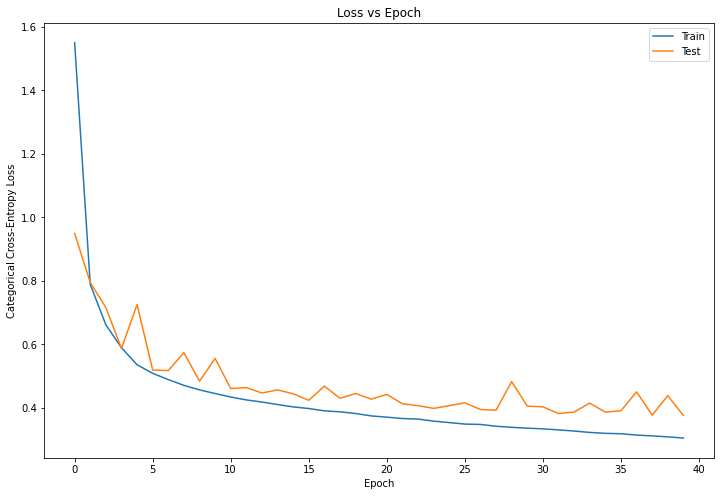

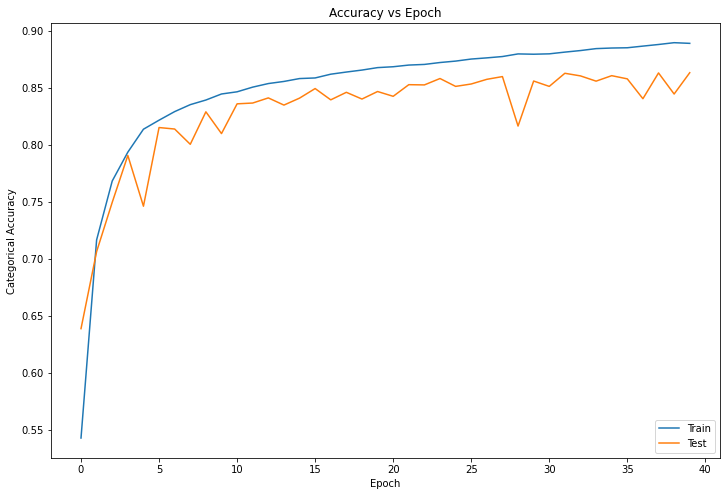

In [17]:
model_1_1_1_.compile(optimizer=SGD(learning_rate=0.01), loss=CategoricalCrossentropy(), metrics=['accuracy'])
x_1_1_1_ = (x_train*1.0)[..., np.newaxis]
y_1_1_1_ = (y_train*1.0)
x_test_1_1_1_ = (x_test*1.0)[..., np.newaxis]
y_test_1_1_1_ = (y_test*1.0)
epochs=40

history_1_1_1_ = model_1_1_1_.fit(x_1_1_1_, y_1_2_2_, batch_size=256, epochs=epochs, validation_data=(x_test_1_1_1_, y_test_1_1_1_), verbose=False)

plot_loss(history_1_1_1_.history['loss'], history_1_1_1_.history['val_loss'])

plot_acc(history_1_1_1_.history['accuracy'], history_1_1_1_.history['val_accuracy'])

In [ ]:
params_1_2_2 = 107266
params_1_1_1 = 959610
print('')

At the bottom of each summar gives number of parameters

1.2.4

TensorShape([28, 28, 1])

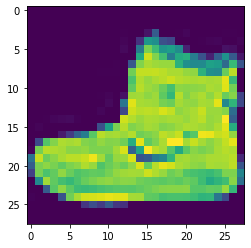

In [575]:
image = tf.convert_to_tensor(x_train[0][..., np.newaxis])
plt.imshow(image)
image.shape

In [576]:
from tensorflow.keras.models import Model
inputs = model_1_2_2_.inputs
outputs = [layer.output for layer in model_1_2_2_.layers]
model_features = Model(inputs=inputs, outputs=outputs)

In [578]:
image_processed = image*1.0
features = model_features(image_processed[tf.newaxis, ...])
features = [image] + features

IndexError: index 2 is out of bounds for axis 0 with size 2

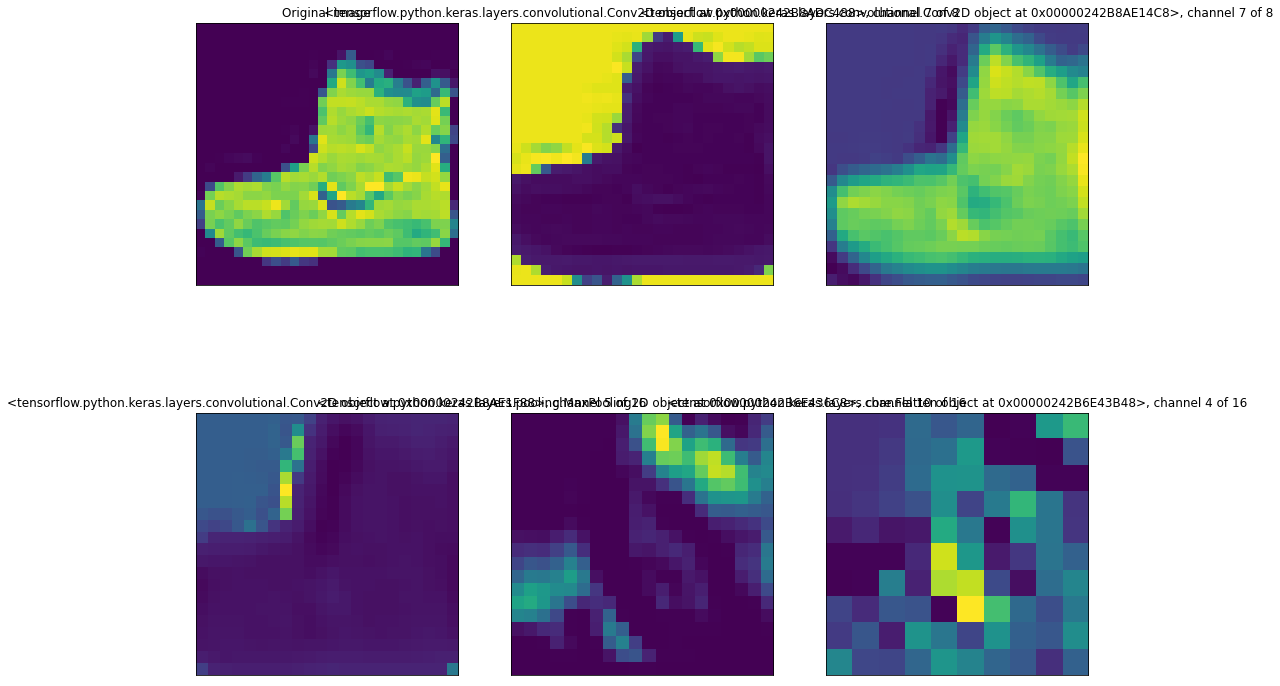

In [580]:
n_rows, n_cols = 2, 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 14))
fig.subplots_adjust(hspace=0.05, wspace=0.2)

for i in range(len(features)):
    feature_map = features[i]
    num_channels = feature_map.shape[-1]
    row = i // n_cols
    col = i % n_cols
    if i == 0:
        axes[row, col].imshow(image)
        axes[row, col].set_title('Original image')
    else:
        random_feature = np.random.choice(num_channels)
        axes[row, col].imshow(feature_map[0, ..., random_feature])
        axes[row, col].set_title('{}, channel {} of {}'.format(model_1_2_2_.layers[i], random_feature + 1, num_channels))
        
    axes[row, col].get_xaxis().set_visible(False)
    axes[row, col].get_yaxis().set_visible(False)
plt.show()

Need to look at one feature map at each layer to see what it is picking up from the image.

<a name="task-2"></a>

# Task 2: Unsupervised learning [^](#outline)

<a name="q21"></a>

## 2.1 Dimensionality reduction and clustering of a subset of  the Fashion-MNIST image data [^](#outline)

2.1.1

In [346]:
from scipy.sparse import linalg

In [470]:
def standardise(X):
    '''
    Create the Weights and biases for a mlp with the given num_neurons.
    This mlp with have n hidden layers.
    
    parameters:
    num_neurons: n+2 1d array of the number of nearons on each layer,
                 starting with input and ending with output
    
    returns:
    Weights: (n+1) x dif x dif list of all kernel matrix parameter arrays
    biases: (n+1) x dif list of all bias parameter arrays
    '''
    
    mu = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    std_filled = std.copy()
    std_filled[std==0] = 1.
    Xbar = ((X-mu)/std_filled)
    return Xbar


def pca_function(X, k):

    # create covariance matrix S
    C = 1.0/(len(X)-1) * np.dot(X.T, X)


    # compute eigenvalues and eigenvectors using the eigsh scipy function
    eigenvalues, eigenvectors = linalg.eigsh(C, k, which="LM", return_eigenvectors=True) 

    # sorting the eigenvectors and eigenvalues from largest to smallest eigenvalue
    sorted_index = np.argsort(eigenvalues)[::-1]
    eigenvalues=eigenvalues[sorted_index]
    eigenvectors=eigenvectors[:, sorted_index]

    # transform our data
    X_pca = X.dot(eigenvectors)

    return X_pca, eigenvectors, eigenvalues

In [494]:
N = 1000
p = 784
x_2_1_1 = standardise(flatten_x(x_train[:N]*1.0))

x_pca, eigenvectors, eigenvalues = pca_function(x_2_1_1, p) 

2.1.2

In [487]:
m = 25
C = 1.0/(len(x_2_1_1)-1) * np.dot(x_2_1_1.T, x_2_1_1)
all_eigenvalues, _ = np.linalg.eig(C)
total_variance = abs(all_eigenvalues.sum())

explained_variances = eigenvalues[:m] /  total_variance
print(f'The explained variance for the first {m} principle components is: {explained_variances}')

The explained variance for the first 25 principle components is: [0.22469307 0.1427811  0.05563787 0.05268032 0.04027674 0.03239235
 0.02757753 0.0245308  0.01782054 0.01458785 0.01248351 0.01141189
 0.01085065 0.00944734 0.0087859  0.00805823 0.00683101 0.00653584
 0.00639082 0.00619386 0.00574918 0.00560928 0.00529806 0.00499833
 0.00472384]


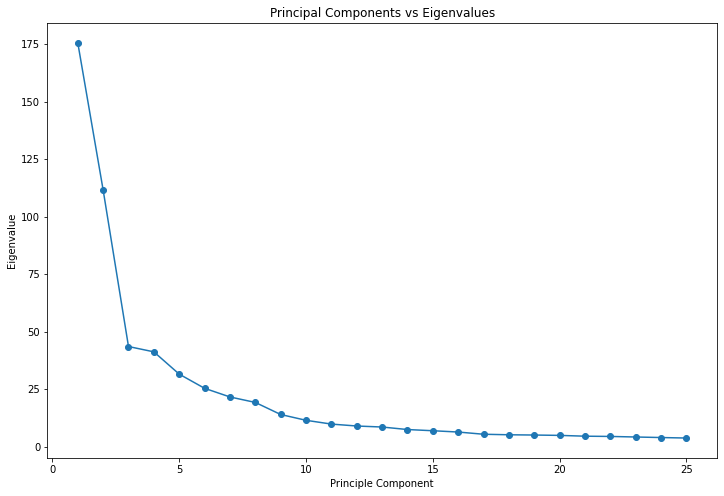

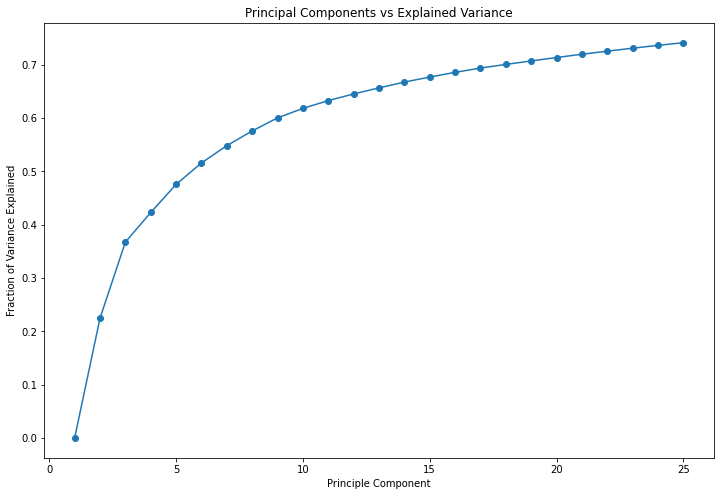

In [488]:
plt.figure(figsize=(12,8))
plt.title('Principal Components vs Eigenvalues')
plt.xlabel('Principle Component')
plt.ylabel('Eigenvalue')
plt.plot(range(1, m+1), eigenvalues[:m], marker='o')
plt.show()

fraction_variances = [sum(explained_variances[:i]) for i in range(m)]

plt.figure(figsize=(12,8))
plt.title('Principal Components vs Explained Variance')
plt.xlabel('Principle Component')
plt.ylabel('Fraction of Variance Explained')
plt.plot(range(1, m+1), fraction_variances, marker='o')
plt.show()

2.1.3

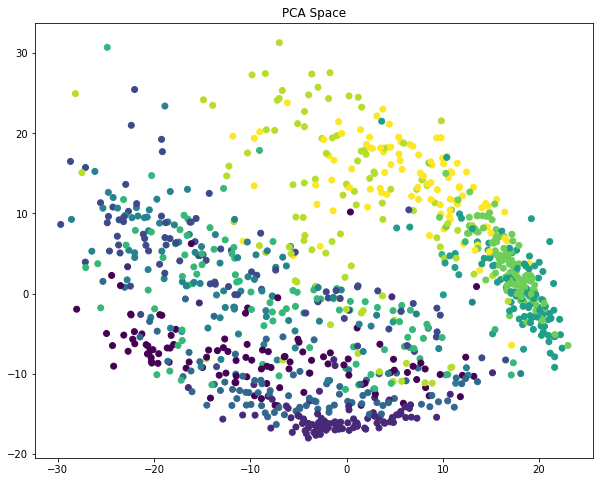

In [525]:
k = 2
x_pca_2 = x_pca[:, :k]*1.0
y_2_1_3 = [np.argmax(y) for y in y_train[:N]]
plt.figure(figsize=(10,8))
plt.title('PCA Space')
plt.scatter(x_pca_2[:, 0],x_pca_2[:, 1], c=y_2_1_3)
plt.show()

2.1.4

In [521]:
def k_means(X, k=2, max_iter=50):
    '''
    k-means clustering algorithm
    
    parameters:
    X: n_samples x n_features array
    k: int of number of classes to classify
    
    returns:
    labels: n_samples 1d array of the class of each X for each sample
    centroids: k x n_features array of the center of each cluster
    '''
    n_samples, n_features = X.shape

    # labels: assign every sample to a cluster at random
    labels = np.random.randint(low=0, high=k, size=n_samples)
    X_labels = np.append(X, labels.reshape(-1,1), axis=1)

    # computing the centroids of each of the k clusters
    centroids = np.zeros((k, n_features))
    for i in range(k):
        centroids[i] = np.mean([x for x in X_labels if x[-1]==i], axis=0)[0:2]

    new_labels = np.zeros(len(X))
    difference = 0

    # k-means algorithm
    for i in range(max_iter):
        # distances: between data points and centroids
        distances = np.array([np.linalg.norm(X - c, axis=1) for c in centroids])
        # new_labels: computed by finding centroid with minimal distance
        new_labels = np.argmin(distances, axis=0)

        if (labels==new_labels).all():
            # labels unchanged
            labels = new_labels
            break
        else:
            # labels changed
            # difference: percentage of changed labels
            difference = np.mean(labels!=new_labels)
            labels = new_labels
            for c in range(k):
                # update centroids by taking the mean over associated data points
                if (labels == c).any():
                    centroids[c] = np.mean(X[labels==c], axis=0)
    return labels, centroids

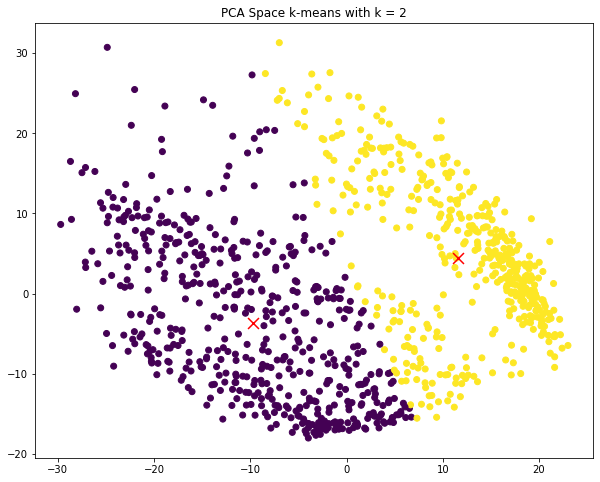

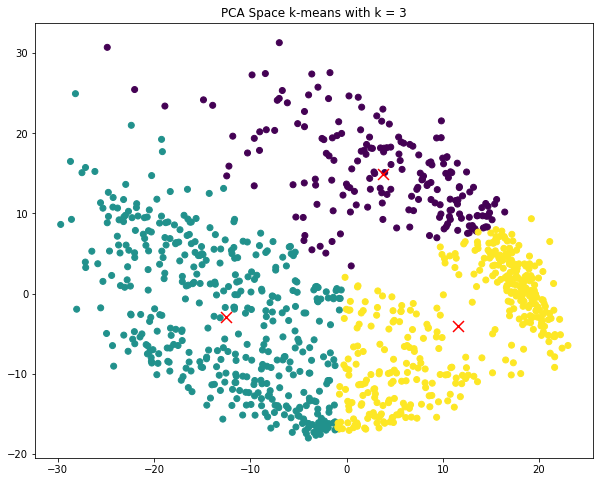

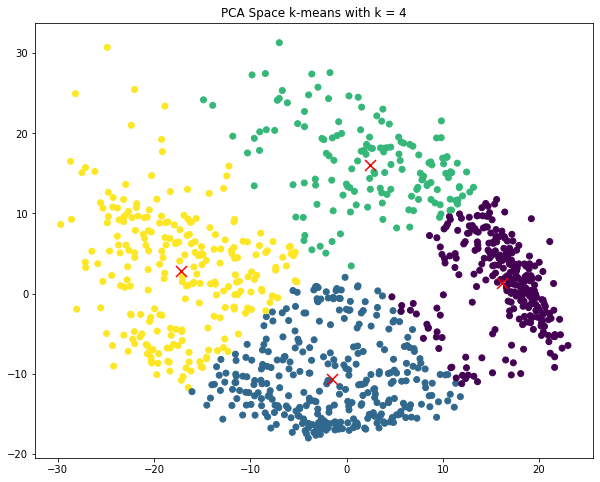

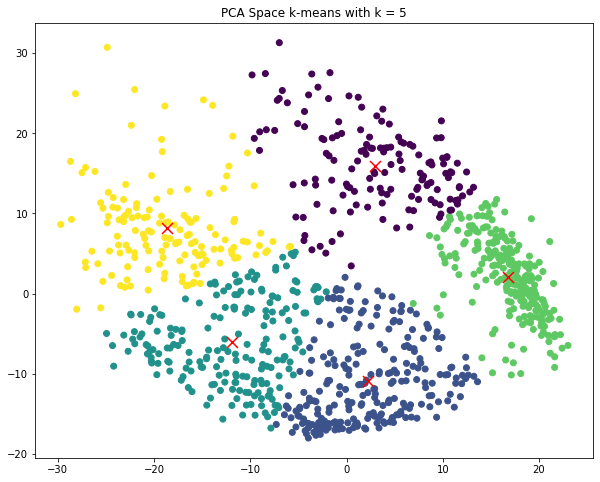

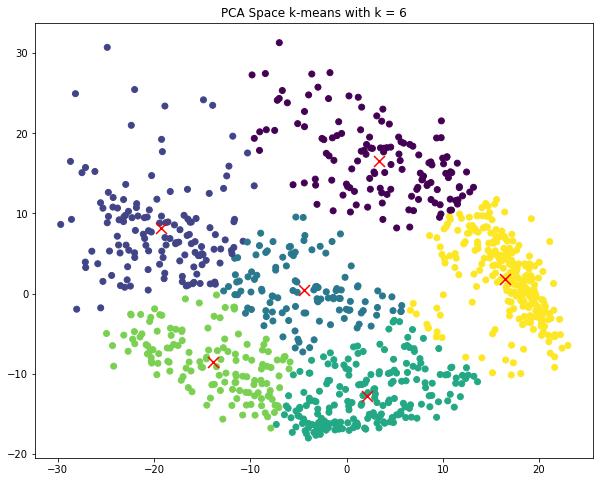

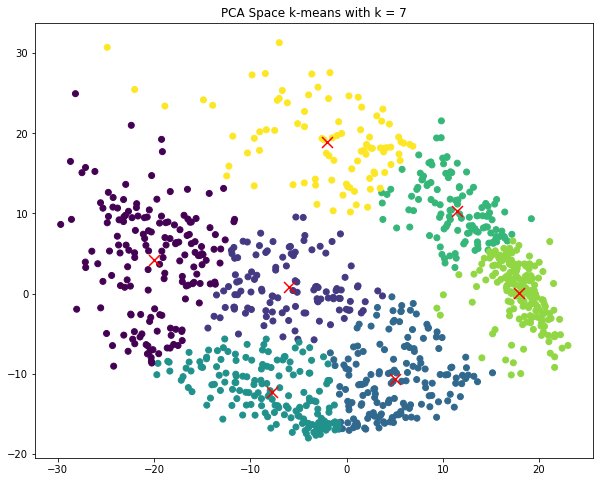

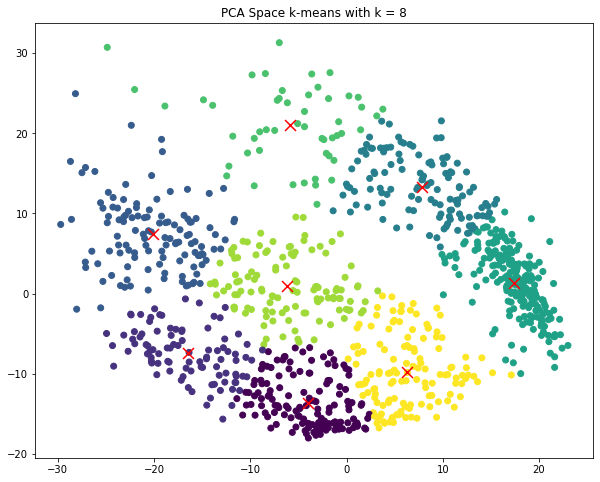

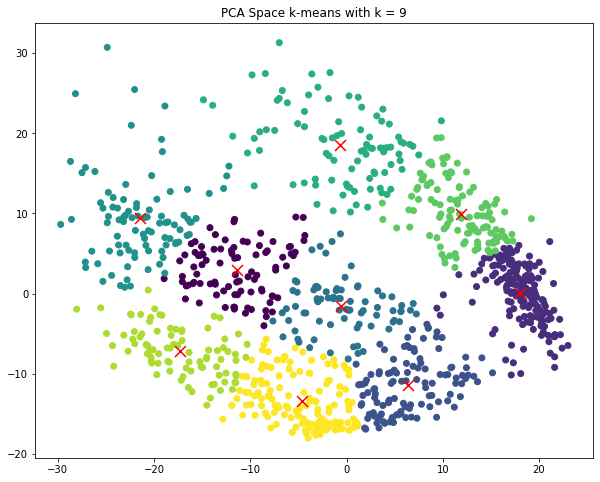

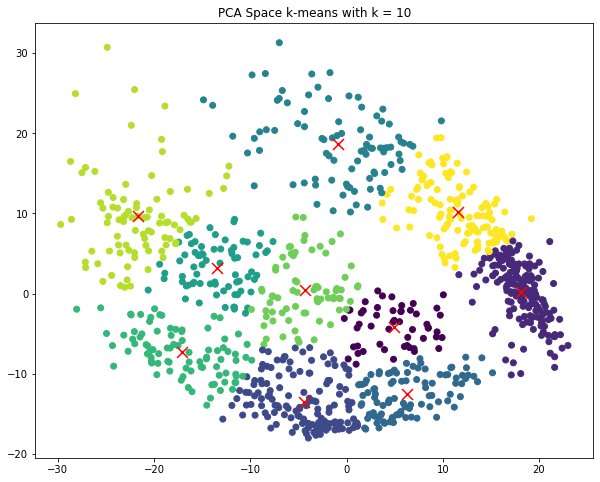

In [526]:
for k in range(2, 11):
    labels, centroids = k_means(x_pca_2, k=k)
    plt.figure(figsize=(10,8))
    plt.title(f'PCA Space k-means with k = {k}')
    plt.scatter(x_pca_2[:, 0], x_pca_2[:, 1], c=labels);
    plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=120);

<a name="q22"></a>

## 2.2 Clustering of the feature matrix [^](#outline)

2.2.1

In [ ]:
import pandas as pd
import networkx as nx

dolphina_F_62x32 = np.load('dolphina_F_62x32.npy')
dolphina_A_62x62 = np.load('dolphina_A_62x62.npy')
dolphin_names = pd.read_csv('dolphin_names.csv', index_col = 0)


In [ ]:
def pairwise_distances(points):
    '''
    parameters:
    points: N x D array of points, where N is the number of points and
            D is the number of features.
    
    returns:
    distance: N x N array such that the element (i, j) is the computed
              distance between i-th point and j-th point.
    '''
    N, D = points.shape
    distance = np.empty((N, N))
    
    # distance matrix will be symmetric, so avoid redundant computations.
    for i in range(N):
        distance[i, i] = 0
        for j in range(i + 1, N):
            d = np.sqrt(np.power(points[i, :] - points[j, :], 2).sum())
            distance[i, j] = d
            distance[j, i] = d    
    return distance


def average_linkage(distances, cluster_assignment, i, j):
    """
    This function computes the average linkage value between two clusters.
    
    parameters:
    distances: N x N array of pair-wise distances for the given points.
    cluster_assignment: N 1d array that assigns a cluster id for every point.
    i: int the first cluster id.
    j: int the second cluster id.
    
    returns:
    pair_distance.mean: The average distance between the two given clusters.
    """
    # Select the point indices of the first cluster.
    points_i = np.argwhere(cluster_assignment == i)
    # Select the point indices of the second cluster.
    points_j = np.argwhere(cluster_assignment == j)
    # Form a cartesian product between the indices in i and indices in j.
    pairs = np.array([[element_i.item(), element_j.item()]  for element_i in points_i for element_j in points_j])
    # Select the pair distances between the points in the two clusters from the distances matrix.
    pairs_distance = distances[pairs[:, 0], pairs[:, 1]]
    # Return the average
    return pairs_distance.mean()


def hierarchical_clustering(points, distances, linkage=average_linkage):
    """
    The hierarchical clustering algorithm start with every point as a single cluster and 
    each iteration merges two clusters into one. We may wish to store all the 
    intermediate clustering results with respect to the number of clusters left.

    parameters:
    points: A numpy array of points having the shape (N, D), 
            where N is the number of points and D is the number of features.
    distances: A numpy array with shape (N, N) such that the element (i, j) is the computed
               distance between i-th point and j-th point in X.
    linkage: A linkage function from the above to call to compute the linkage values between two clusters.

    returns:
    assignments: N x N array of which each row stores the clustering assignment at each level.
                 The first row, i.e. a[0, :], represents the highest level of clustering where all columns have the same index value.
                 The second row, i.e. a[1, :], represents all the points assigned into two cluster indices.
                 The last row, i.e. a[N - 1, :], represents the points assigned into N - 1 cluster indices.
    """ 
    N, D = points.shape
    assignments = np.zeros((N, N))
    
    # Begin with every point is its own cluster
    current_assignment = np.arange(N)
    
    # The id to be assigned for the next merged cluster
    next_cluster_id = N
    
    # Begin from level (N - 1) to level 1
    for level in range(N - 1, 0, -1):
        cluster_ids = np.unique(current_assignment)
        
        min_d = np.inf
        
        # Initialize the cluster ids to be merged in this iteration.
        cluster_a, cluster_b = (-1, -1) 
        
        # Now find the two clusters that have the minimum distance in between.
        for i in range(cluster_ids.size):
            for j in range(i + 1, cluster_ids.size):
                cluster_i = cluster_ids[i]
                cluster_j = cluster_ids[j]
                d = linkage(distances, current_assignment, cluster_i, cluster_j)    ## <-- EDIT THIS LINE
                if d < min_d:
                    min_d = d
                    cluster_a, cluster_b = (cluster_i, cluster_j)
        
        # Merge the two clusters
        current_assignment[(current_assignment == cluster_a) | (current_assignment == cluster_b)] = next_cluster_id
        next_cluster_id += 1
        # Store the current cluster assignment into the assignments array.
        assignments[level, :] = current_assignment
        
    return assignments

In [ ]:
X = dolphins_F_62x32*1.0
A = dolphins_A_62x62*1.0
d = pairwise_distances(X)
a = hierarchical_clustering(X, d)

In [ ]:
nrow = 12; ncol = 5;
fig, axs = plt.subplots(nrows=nrow, ncols=ncol,figsize=(30,30))

for i,ax in enumerate(axs.reshape(-1)): 
    ax.set_title(f'Separated into {i+2} clusters')
    nx.draw(nx.from_numpy_array(A), node_color=a[i+2], ax=ax)

<a name="q23"></a>

## 2.3 Graph-based analysis  [^](#outline)